# This notebook is to compute purity/stability plots and response matrices of tau1...tau4 with chosen binnings

In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi,tdrstyle
tdrstyle.setTDRStyle()
rt.gROOT.SetBatch()
rt.gROOT.ForceStyle()
rt.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms with new binning schemes

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and Stability Computation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Variables

In [6]:
variables=['tau_0p5_0','tau_1_0','tau_2_0','tau_0p5_1','tau_1_1','tau_2_1','tau_0p5_2','tau_1_2','tau_2_2','tau_0p5_3','tau_1_3','tau_2_3']
reco={}
gen={}
resp={}
sysunc={}
title={}
for var in variables:
    reco[var]='recoJet_'+var+'_nom_dijetSel'
    gen[var]='genJet_'+var+'_dijetSel'
    resp[var]='respJet_'+var+'_nom_dijetSel'
    for source in ['jesTotal',"jer","pu"]:
        for ud in ['Up','Down']:
            sysunc[var+source+ud]='respJet_'+var+'_'+source+ud+'_dijetSel'
    title[var]='#tau_{'+str(int(var.split('_')[2])+1)+'}^{'+('(0.5)' if 'p' in var.split('_')[1] else '('+var.split('_')[1]+')')+'}'
print title

{'tau_1_0': '#tau_{1}^{(1)}', 'tau_1_1': '#tau_{2}^{(1)}', 'tau_1_2': '#tau_{3}^{(1)}', 'tau_1_3': '#tau_{4}^{(1)}', 'tau_2_3': '#tau_{4}^{(2)}', 'tau_2_2': '#tau_{3}^{(2)}', 'tau_2_1': '#tau_{2}^{(2)}', 'tau_2_0': '#tau_{1}^{(2)}', 'tau_0p5_2': '#tau_{3}^{(0.5)}', 'tau_0p5_3': '#tau_{4}^{(0.5)}', 'tau_0p5_0': '#tau_{1}^{(0.5)}', 'tau_0p5_1': '#tau_{2}^{(0.5)}'}


# Read histograms from files

In [10]:
MC1_0={}
MC2_0={}
for var in variables:
    MC1_0[var]=rt.TH2D("Response1_0:"+title[var],"Response1_0:"+title[var]+';'+title[var]+' gen;'+title[var]+' reco',100,0,1,100,0,1)
    MC2_0[var]=rt.TH2D("Response2_0:"+title[var],"Response2_0:"+title[var]+';'+title[var]+' gen;'+title[var]+' reco',100,0,1,100,0,1)
    
f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
for var in variables:
    MC1_0[var].Add(t.Get(resp[var]),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    for var in variables:
        MC2_0[var].Add(t.Get(resp[var]),Scale[i])
    f_MC[i].Close()

# Chosen binning schemes for each variable

In [9]:
gen_bins={}
reco_bins={}
gen_bins[variables[0]]=np.array([0.0,0.12,0.18,0.24,0.3,0.36,0.42,0.48,0.54,0.6,0.66,0.72,0.81])
reco_bins[variables[0]]=np.array([0.0,0.06,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.51,0.54,0.57,0.6,0.63,0.66,0.69,0.72,0.76,0.81])
gen_bins[variables[1]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.48,0.66])
reco_bins[variables[1]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.57,0.66])
gen_bins[variables[2]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.46])
reco_bins[variables[2]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.36,0.46])
gen_bins[variables[3]]=np.array([0.0,0.08,0.14,0.2,0.26,0.32,0.38,0.44,0.5,0.56,0.68])
reco_bins[variables[3]]=np.array([0.0,0.04,0.08,0.11,0.14,0.17,0.2,0.23,0.26,0.29,0.32,0.35,0.38,0.41,0.44,0.47,0.5,0.53,0.56,0.62,0.68])
gen_bins[variables[4]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.47])
reco_bins[variables[4]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.37,0.47])
gen_bins[variables[5]]=np.array([0.0,0.02,0.04,0.06,0.08,0.12,0.24])
reco_bins[variables[5]]=np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.1,0.12,0.18,0.24])
gen_bins[variables[6]]=np.array([0.0,0.06,0.12,0.18,0.24,0.3,0.36,0.56])
reco_bins[variables[6]]=np.array([0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.47,0.56])
gen_bins[variables[7]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.32])
reco_bins[variables[7]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.26,0.32])
gen_bins[variables[8]]=np.array([0.0,0.02,0.04,0.06,0.14])
reco_bins[variables[8]]=np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.1,0.14])
gen_bins[variables[9]]=np.array([0.0,0.06,0.12,0.18,0.24,0.3,0.36,0.49])
reco_bins[variables[9]]=np.array([0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.33,0.36,0.42,0.49])
gen_bins[variables[10]]=np.array([0.0,0.02,0.04,0.06,0.1,0.14,0.18,0.26])
reco_bins[variables[10]]=np.array([0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.19,0.26])
gen_bins[variables[11]]=np.array([0.0,0.02,0.04,0.09])
reco_bins[variables[11]]=np.array([0.0,0.01,0.02,0.03,0.04,0.06,0.09])
#gen_bins[variables[9]]=np.array([0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.41])
#reco_bins[variables[9]]=np.array([0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.32,0.41])
#gen_bins[variables[10]]=np.array([0.0,0.02,0.04,0.08,0.12,0.23])
#reco_bins[variables[10]]=np.array([0.0,0.01,0.02,0.03,0.04,0.06,0.08,0.1,0.12,0.16,0.23])
#gen_bins[variables[11]]=np.array([0.0,0.02,0.1])
#reco_bins[variables[11]]=np.array([0.0,0.01,0.02,0.05,0.1])
for i in range(12):
    print gen_bins[variables[i]],gen_bins[variables[i]].shape[0]-1
    print reco_bins[variables[i]],reco_bins[variables[i]].shape[0]-1

[0.   0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.81] 12
[0.   0.06 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39 0.42 0.45
 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.76 0.81] 24
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.66] 13
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.57 0.66] 26
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.46] 8
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.36 0.46] 16
[0.   0.08 0.14 0.2  0.26 0.32 0.38 0.44 0.5  0.56 0.68] 10
[0.   0.04 0.08 0.11 0.14 0.17 0.2  0.23 0.26 0.29 0.32 0.35 0.38 0.41
 0.44 0.47 0.5  0.53 0.56 0.62 0.68] 20
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.47] 8
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.37 0.47] 16
[0.   0.02 0.04 0.06 0.08 0.12 0.24] 6
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.1  0.12 0.18 0.24] 12
[0.   0.06 0.12 0.18 0.

# Refill histograms with new binnings, compute purity and stability

In [38]:
purity1={}
stability1={}
MC1={}
purity2={}
stability2={}
MC2={}
for var in variables:
    
    gen_bin=gen_bins[var]
    reco_bin=reco_bins[var]
    
    #Pythia flat in pt
    MC1[var]=rt.TH2D("Response Matrix (Pythia8)","Response Matrix (Pythia8);"+title[var]+" gen;"+title[var]+" reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    Fill2D(MC1_0[var],MC1[var],gen_bin,reco_bin)
    MC1[var].SetStats()
    purity1[var],stability1[var]=PurityStability(MC1_0[var],gen_bin)
    
    #Pythia binned by pt
    MC2[var]=rt.TH2D("Response Matrix (Pythia8_ptbinned)","Response Matrix (Pythia8_ptbinned);"+title[var]+" gen;"+title[var]+" reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    Fill2D(MC2_0[var],MC2[var],gen_bin,reco_bin)
    MC2[var].SetStats()
    purity2[var],stability2[var]=PurityStability(MC2_0[var],gen_bin)

Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (Pythia8) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (Pythia8_ptbinned) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (Pythia8) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak)

In [18]:
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV="36 fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13

# QCD_pythia_flat

yes
yes


Warning in <TCanvas::Constructor>: Deleting canvas with same name: rmtau_0p5_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: pstau_0p5_0
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_dijetSel/PurityStabilitytau_0p5_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: rmtau_1_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: pstau_1_0
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_dijetSel/PurityStabilitytau_1_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: rmtau_2_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: pstau_2_0
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_dijetSel/PurityStabilitytau_2_0.png has been created
Warning in <T

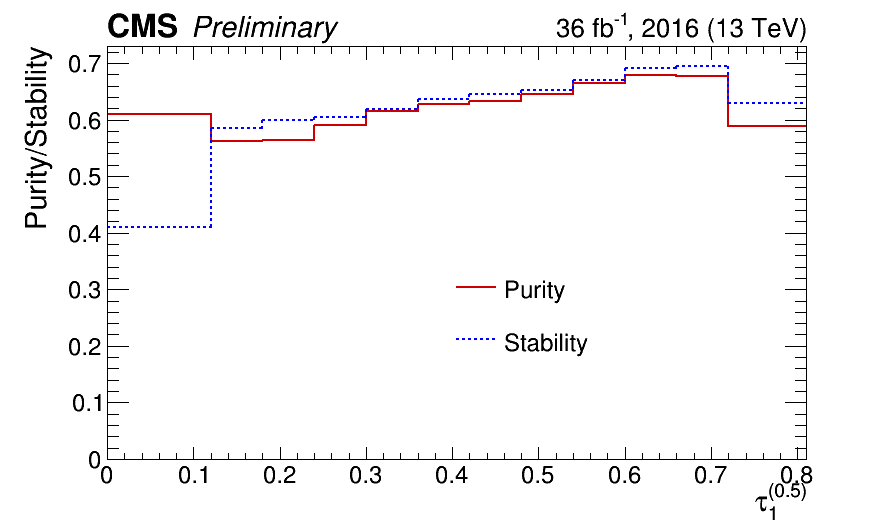

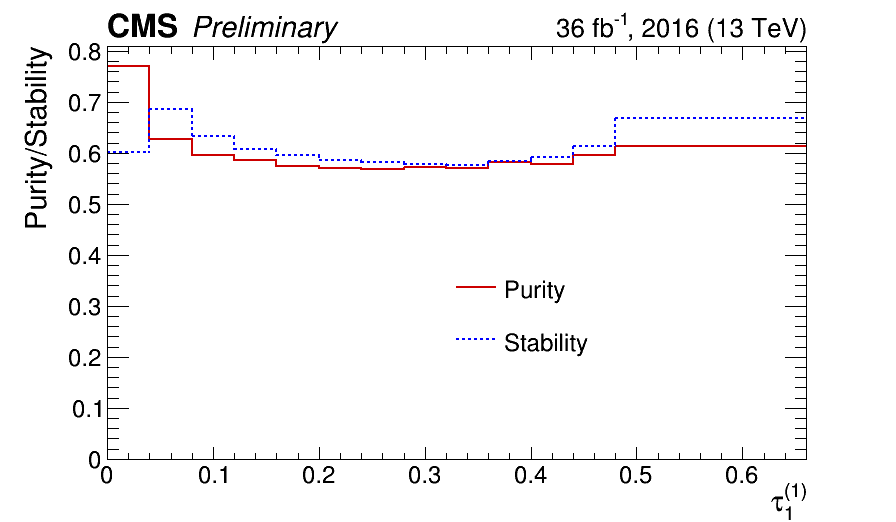

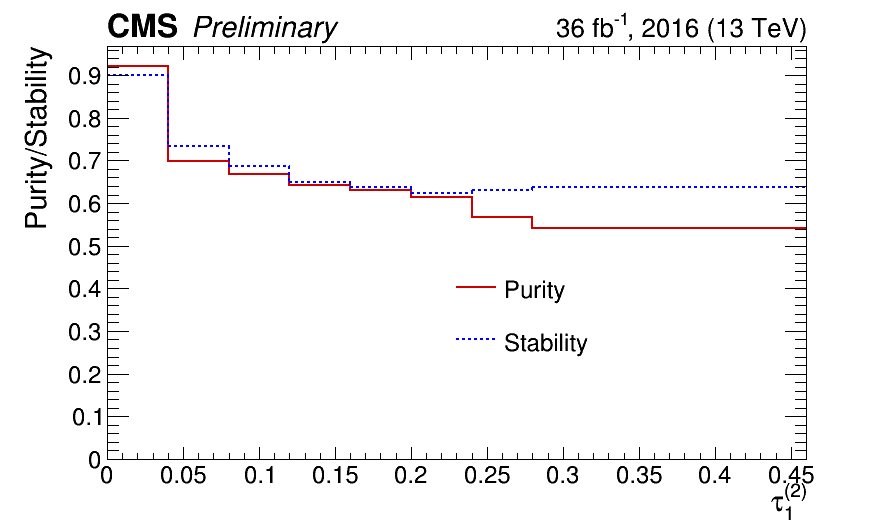

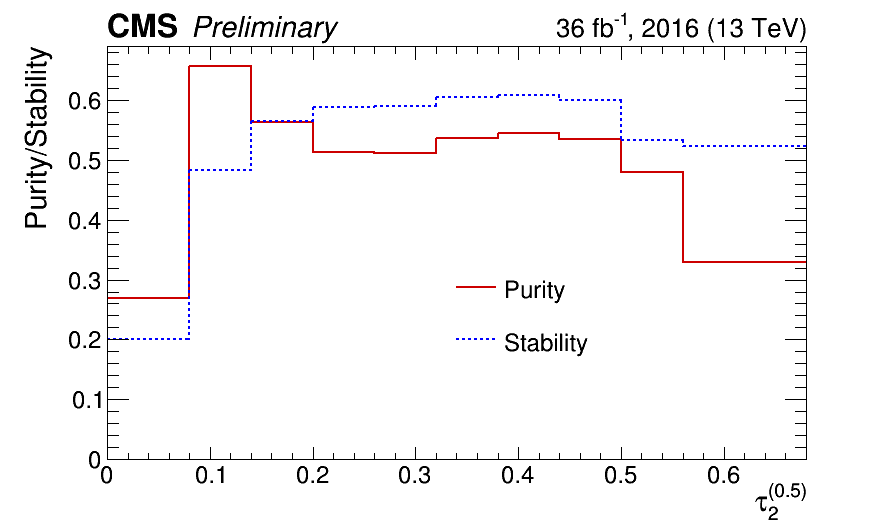

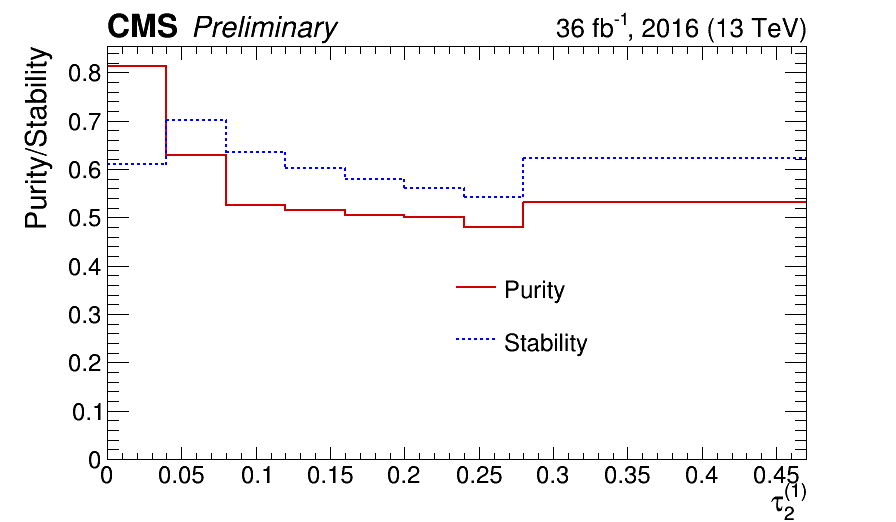

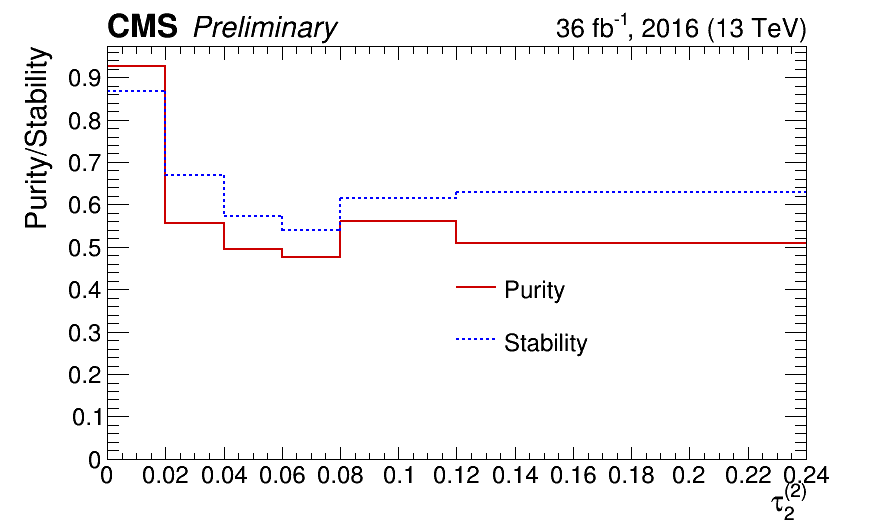

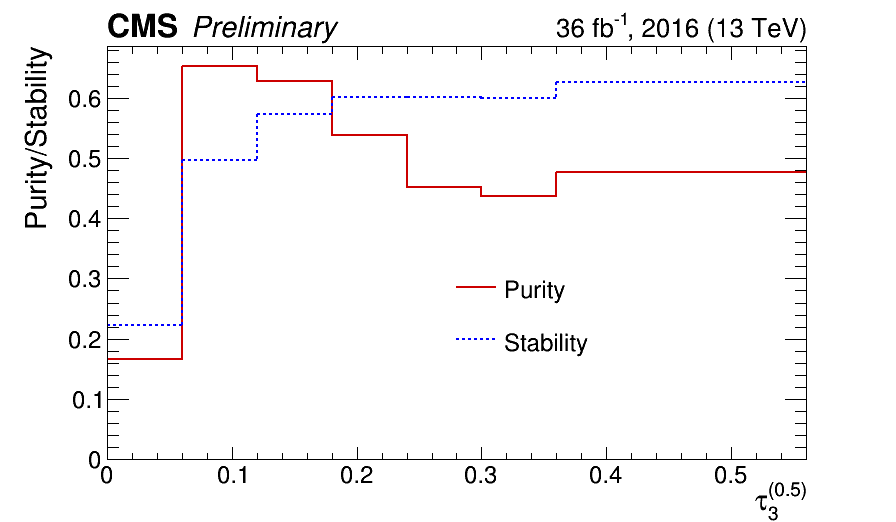

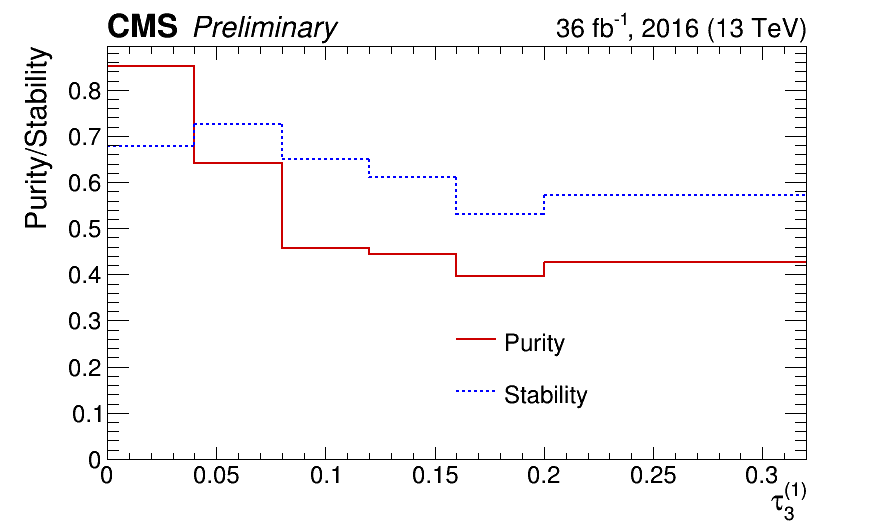

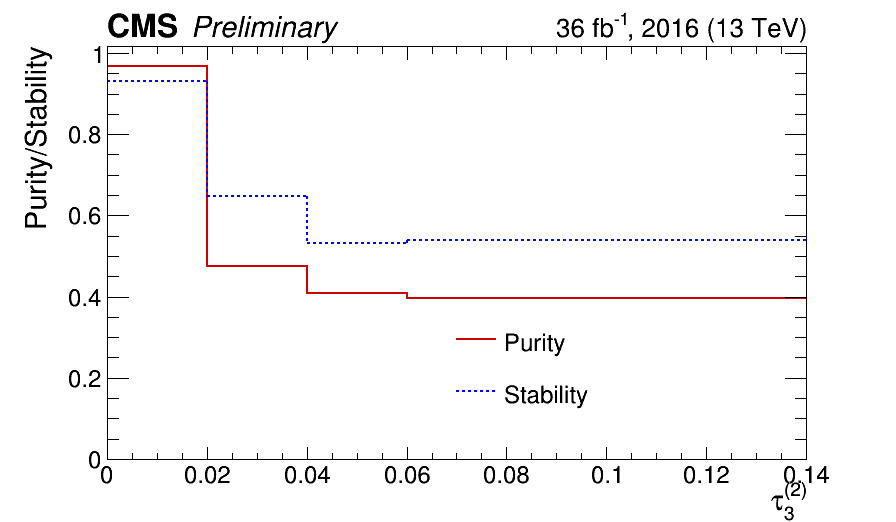

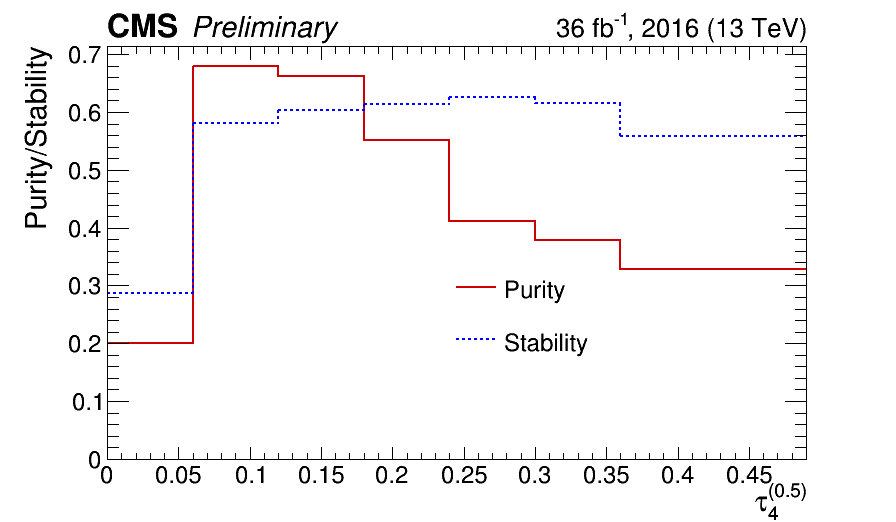

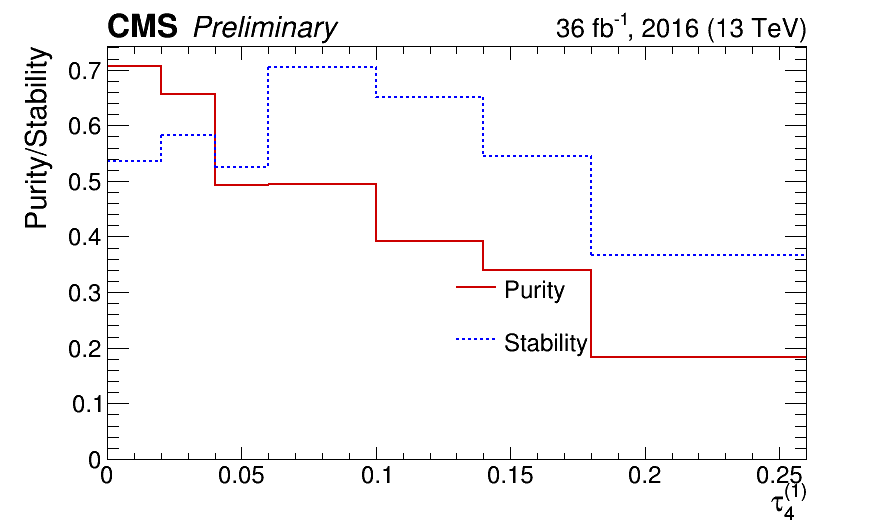

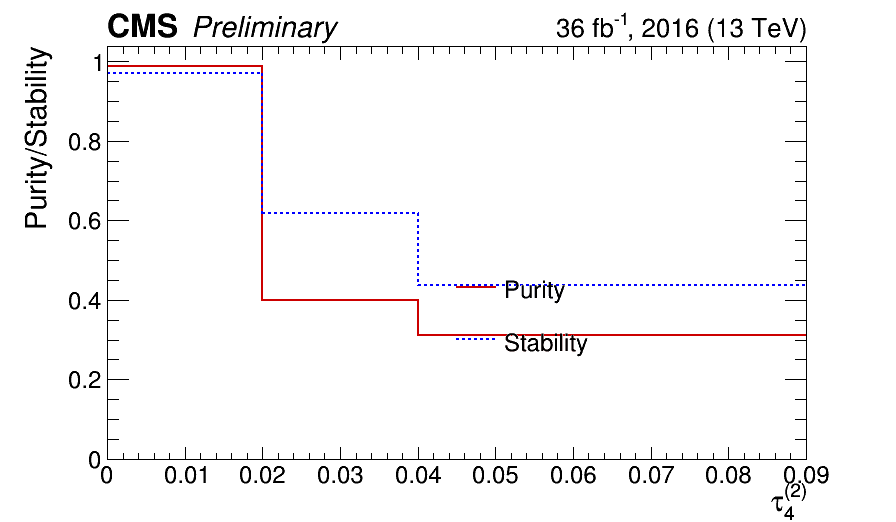

In [81]:
ps={}#stack of purity and stability
cps={}#canvas_purity_stability
crm={}#canvas_response_matrices
leg={}
for var in variables:
    
    CMS_lumi.lumiTextSize=0.4
    CMS_lumi.cmsTextSize=0.5
    CMS_lumi.extraOverCmsTextSize=0.7
    CMS_lumi.relPosX=0.13
    crm[var]=rt.TCanvas("rm"+var,"rm"+var,0,0,900,800)
    crm[var].SetLogz()
    MC1[var].GetXaxis().SetTitleSize(0.05)
    MC1[var].GetXaxis().SetLabelSize(0.04)
    MC1[var].GetYaxis().SetTitleSize(0.05)
    MC1[var].GetYaxis().SetTitleOffset(0.9)
    MC1[var].GetYaxis().SetLabelSize(0.04)
    MC1[var].GetZaxis().SetLabelSize(0.035)
    MC1[var].GetZaxis().SetLabelOffset(-0.002)
    MC1[var].Draw("Colz")
    CMS_lumi.CMS_lumi(crm[var],4,0)
    #crm[var].Draw()
    #crm[var].SaveAs("/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_dijetSel/Response"+var+".png")
    
    CMS_lumi.lumiTextSize=0.6
    CMS_lumi.cmsTextSize=0.75
    CMS_lumi.extraOverCmsTextSize=0.9
    CMS_lumi.relPosX=0.12
    cps[var]=rt.TCanvas("ps"+var,"ps"+var,0,0,900,550)
    ps[var]=rt.THStack("","")
    purity1[var].SetLineStyle(1)
    purity1[var].SetLineColor(rt.kRed+1)
    stability1[var].SetLineStyle(2)
    stability1[var].SetLineColor(rt.kBlue)
    ps[var].Add(purity1[var],"hist")
    ps[var].Add(stability1[var],"hist")
    ps[var].Draw("nostack")
    ps[var].GetXaxis().SetTitle(title[var])
    ps[var].GetYaxis().SetTitle("Purity/Stability")
    ps[var].GetYaxis().SetTitleSize(0.06)
    ps[var].GetYaxis().SetTitleOffset(0.8)
    ps[var].GetXaxis().SetTitleOffset(0.85)
    if var is "tau_1_2" or var is "tau_2_2":
        print "yes"
        leg[var]=rt.TLegend(0.5,0.2,0.75,0.4)
    else:
        leg[var]=rt.TLegend(0.5,0.3,0.75,0.5)
    leg[var].AddEntry(purity1[var],"Purity","l")
    leg[var].AddEntry(stability1[var],"Stability","l")
    leg[var].SetLineColor(0)
    leg[var].SetBorderSize(0)
    leg[var].SetFillStyle(0)
    leg[var].SetTextSize(0.05)
    leg[var].Draw("Same")
    CMS_lumi.CMS_lumi(cps[var],4,0)
    cps[var].Draw()
    cps[var].SaveAs("/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_dijetSel/PurityStability"+var+".png")

# QCD_pythia_ptbinned

yes
yes


Warning in <TCanvas::Constructor>: Deleting canvas with same name: rmtau_0p5_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: pstau_0p5_0
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStabilitytau_0p5_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: rmtau_1_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: pstau_1_0
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStabilitytau_1_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: rmtau_2_0
Warning in <TCanvas::Constructor>: Deleting canvas with same name: pstau_2_0
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStabilitytau_2_0.png has

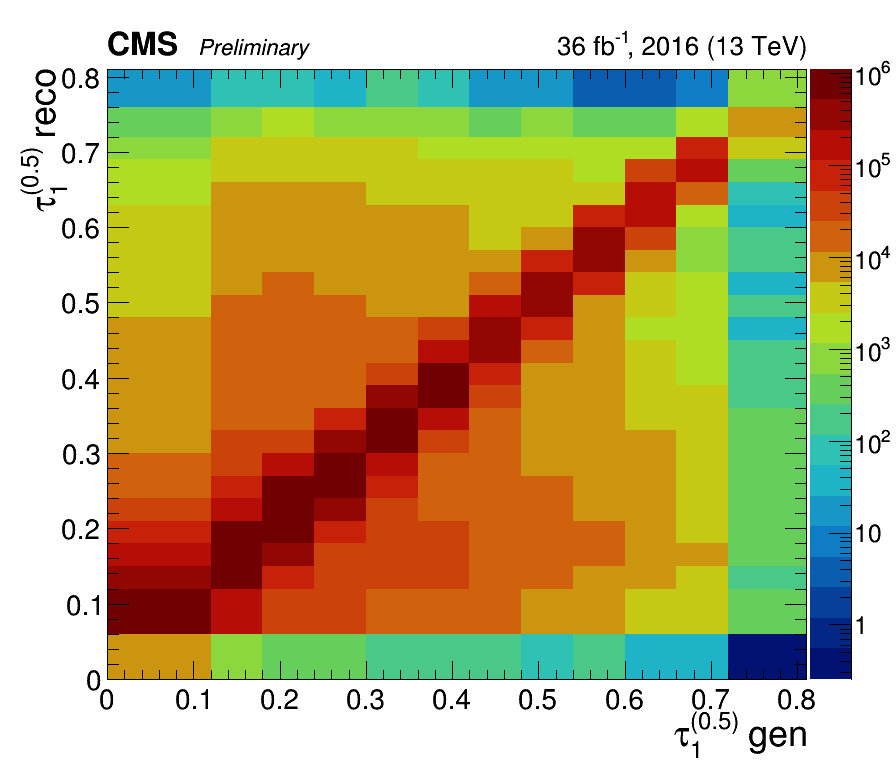

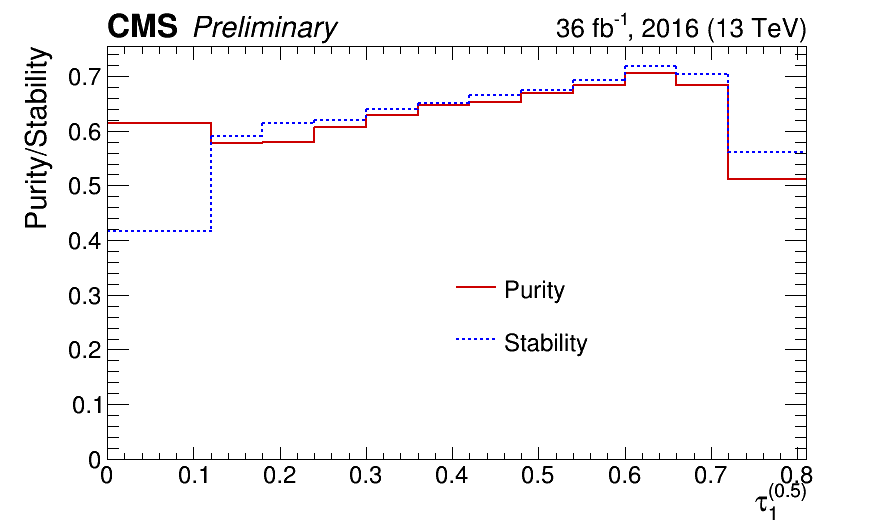

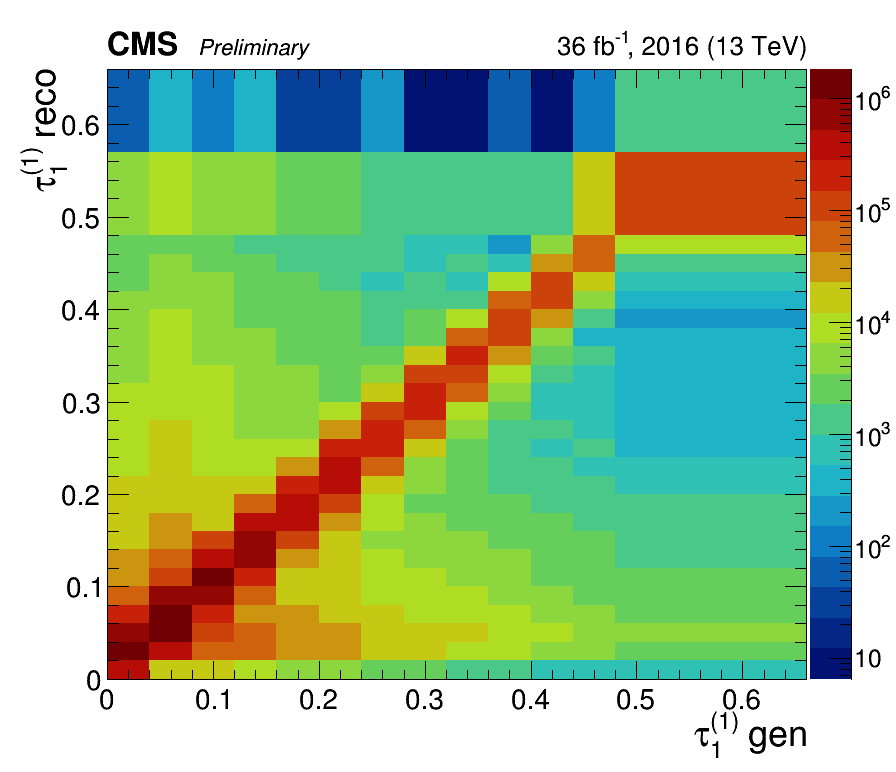

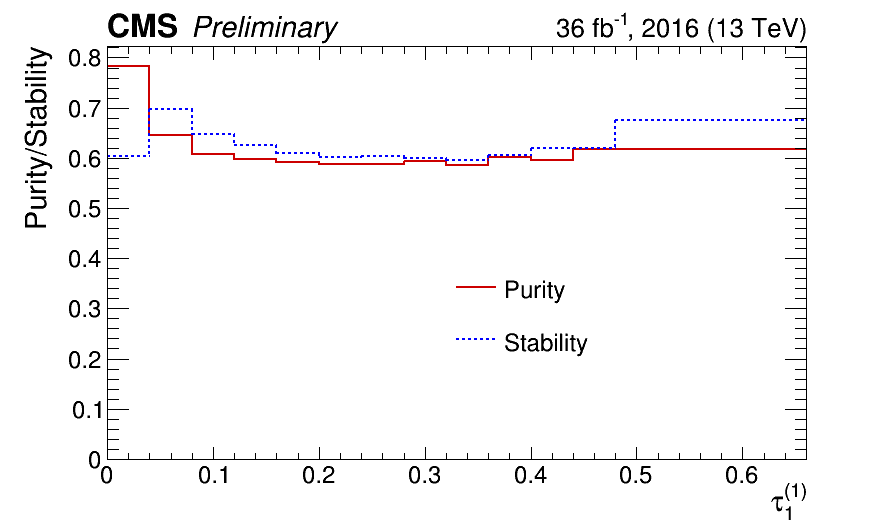

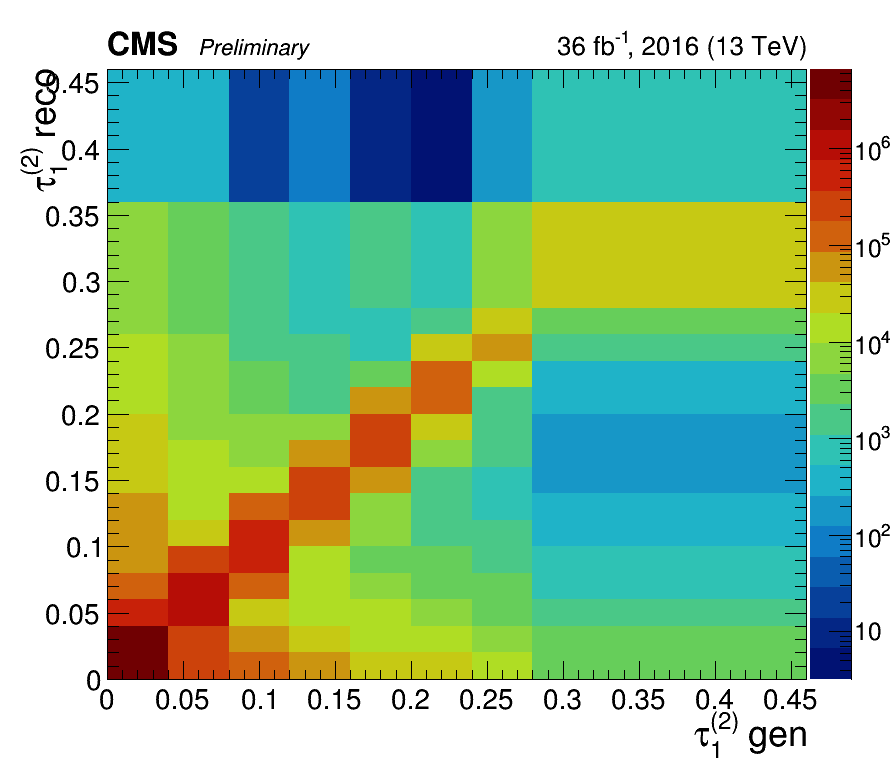

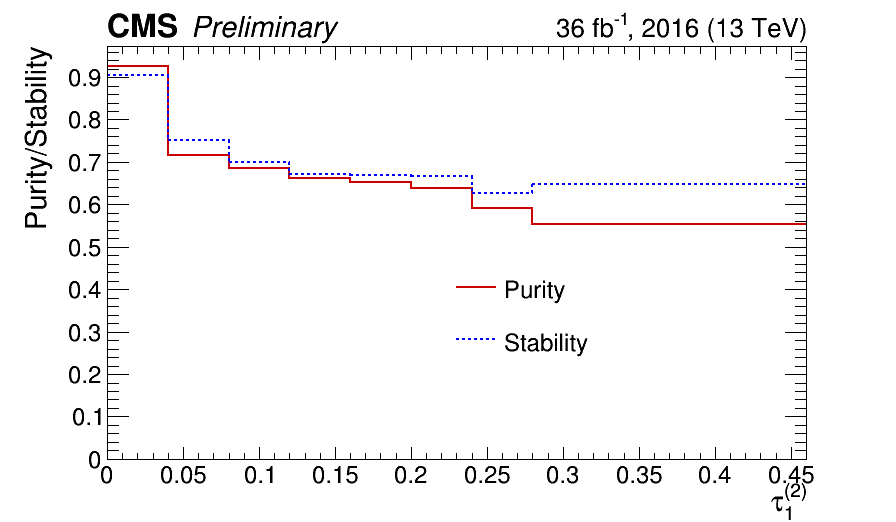

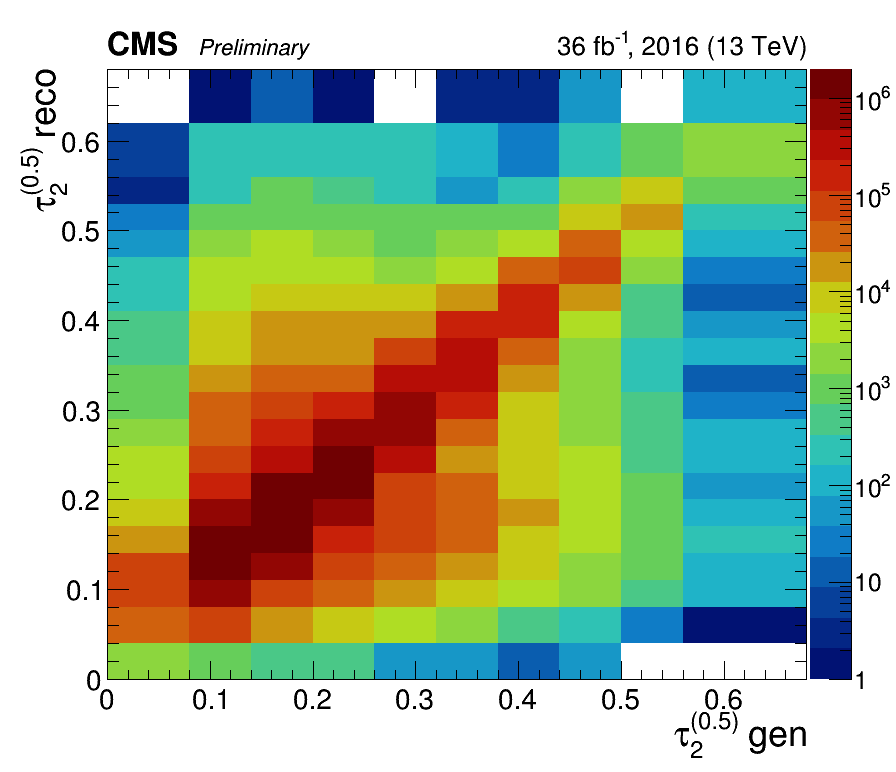

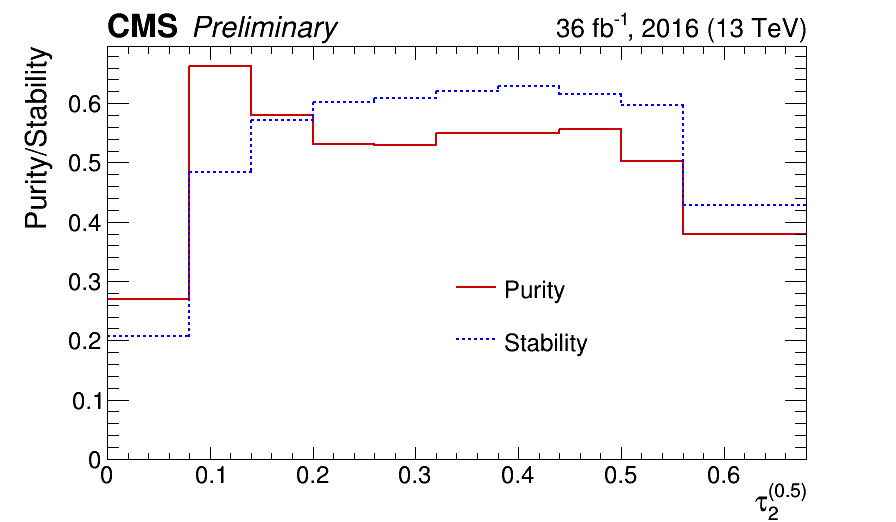

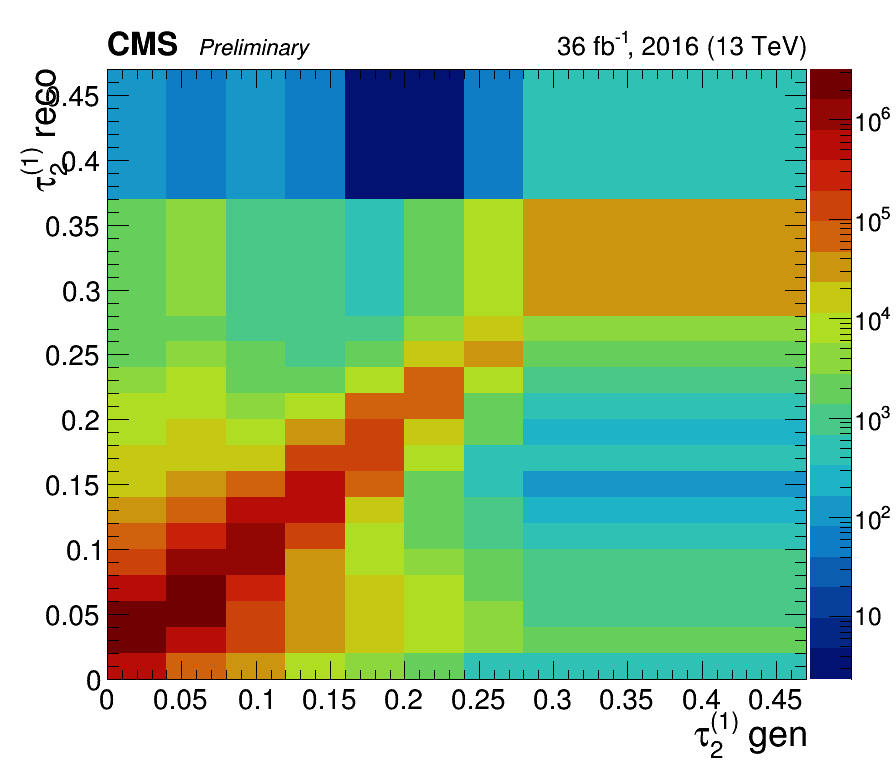

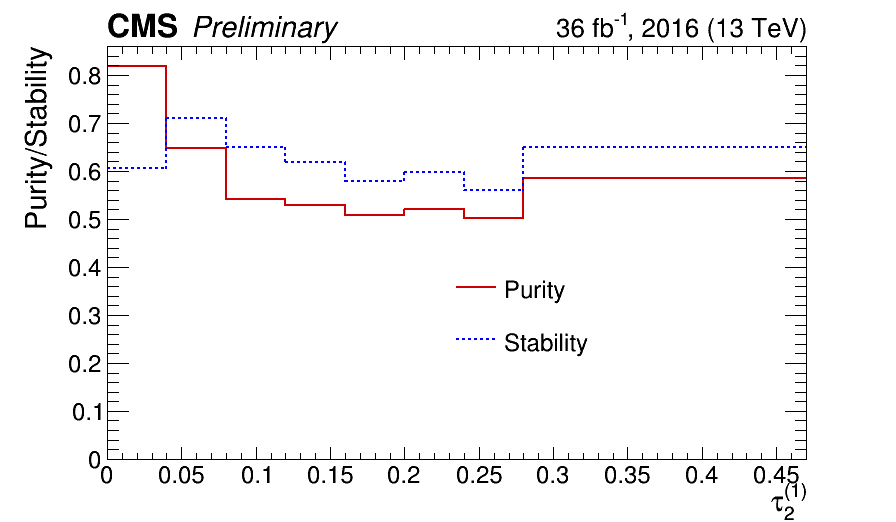

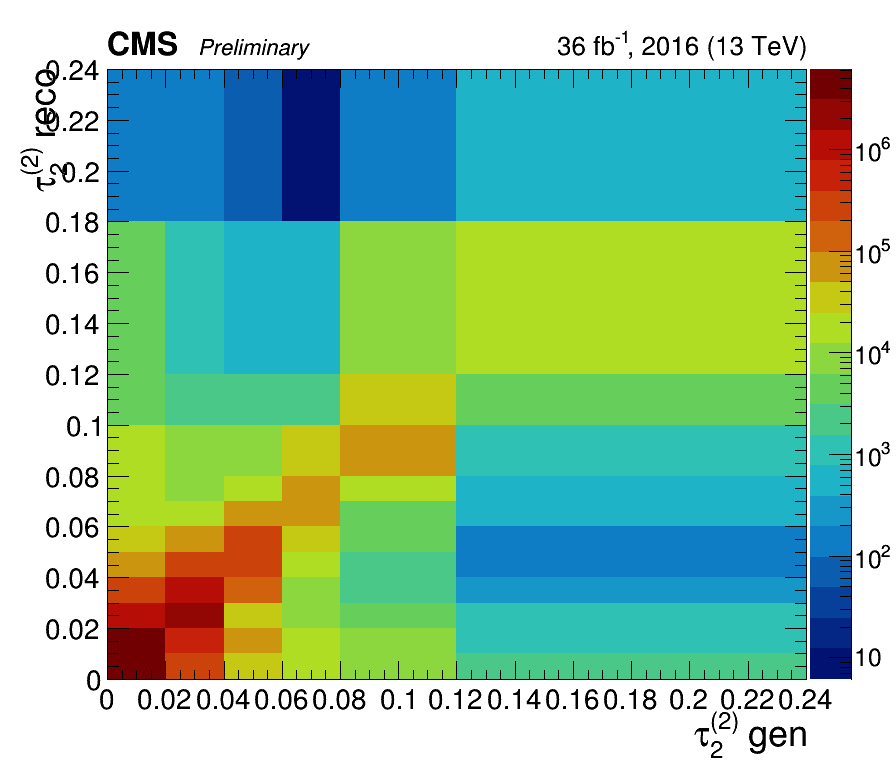

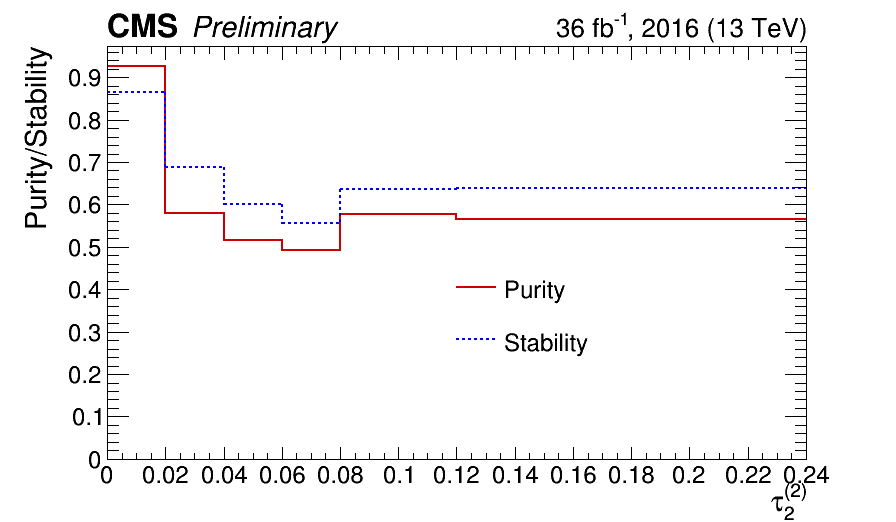

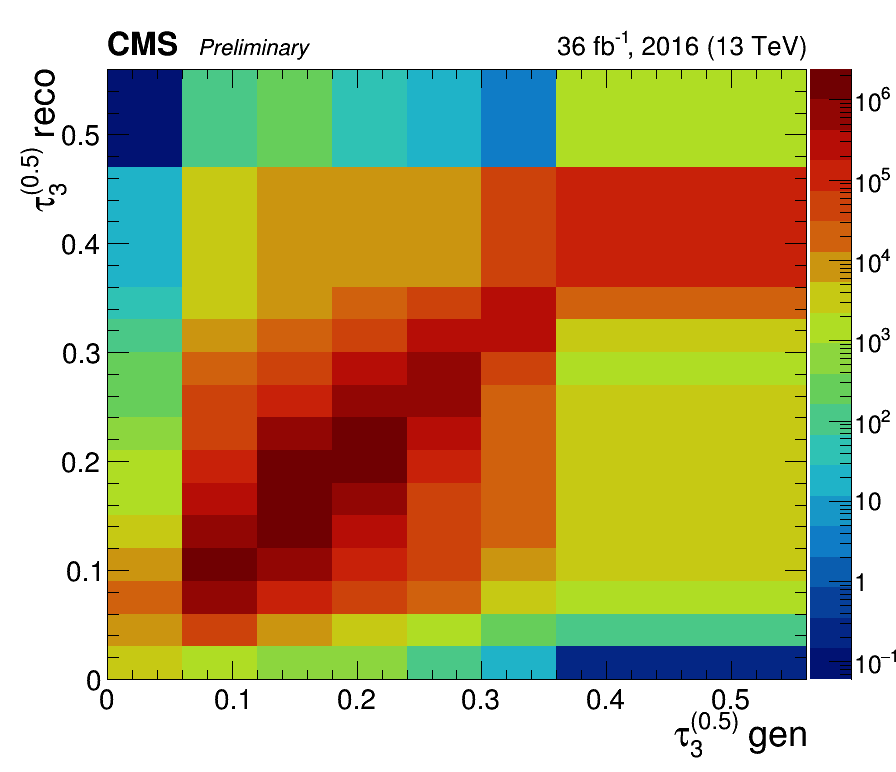

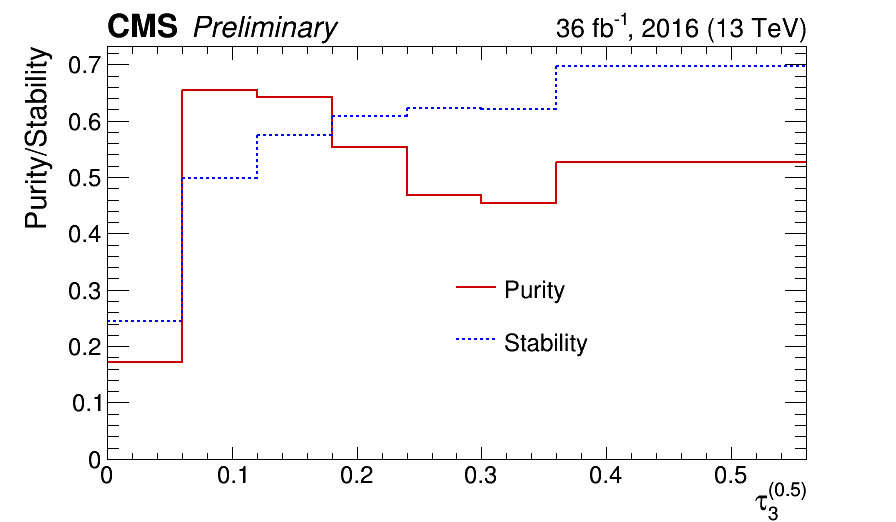

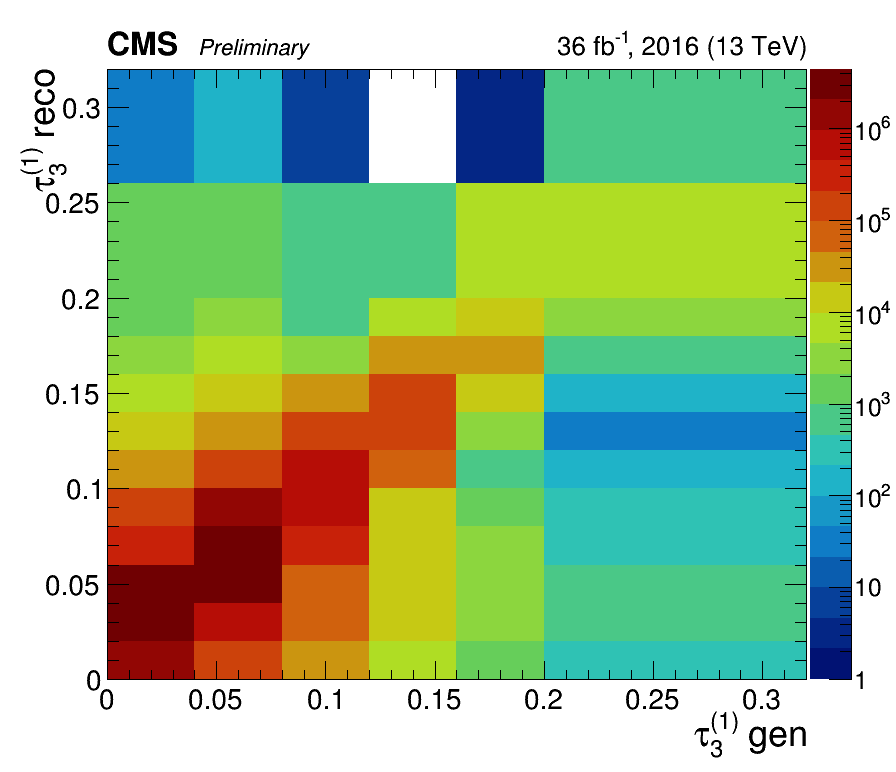

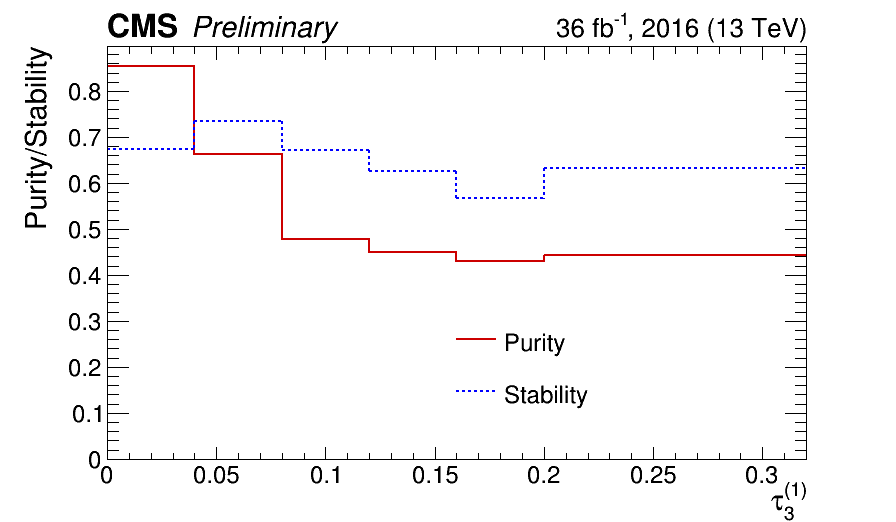

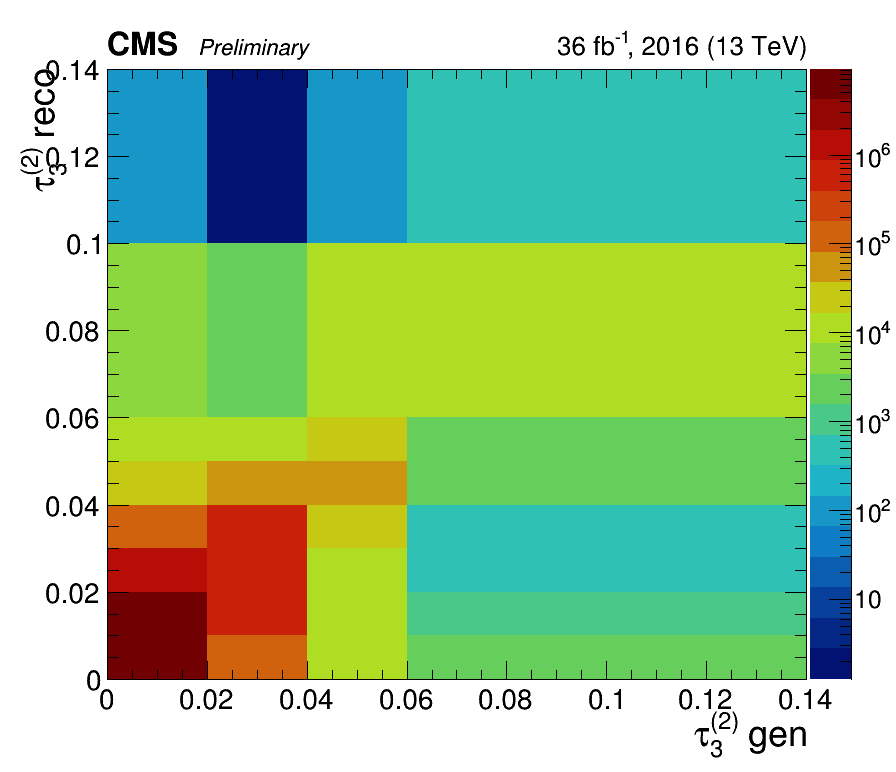

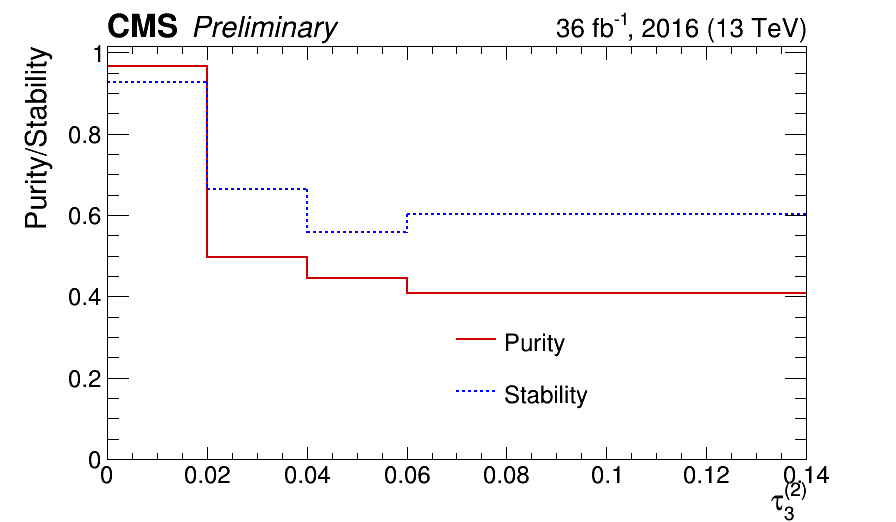

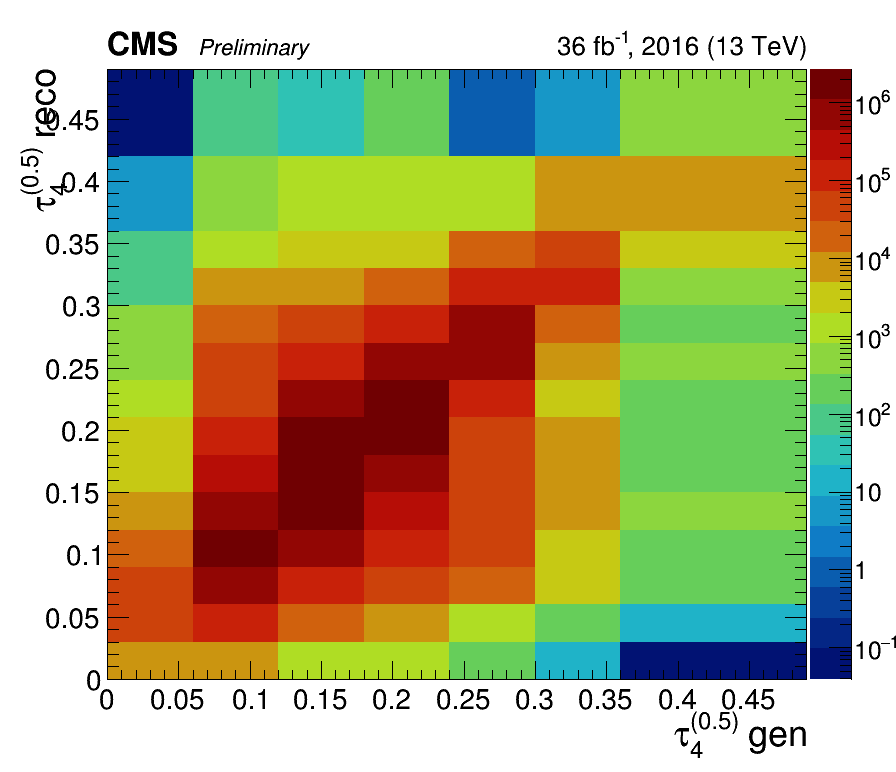

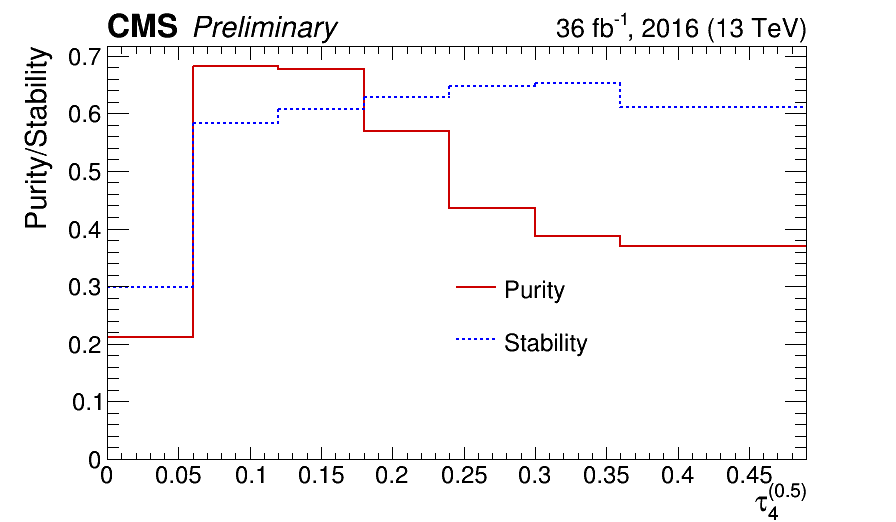

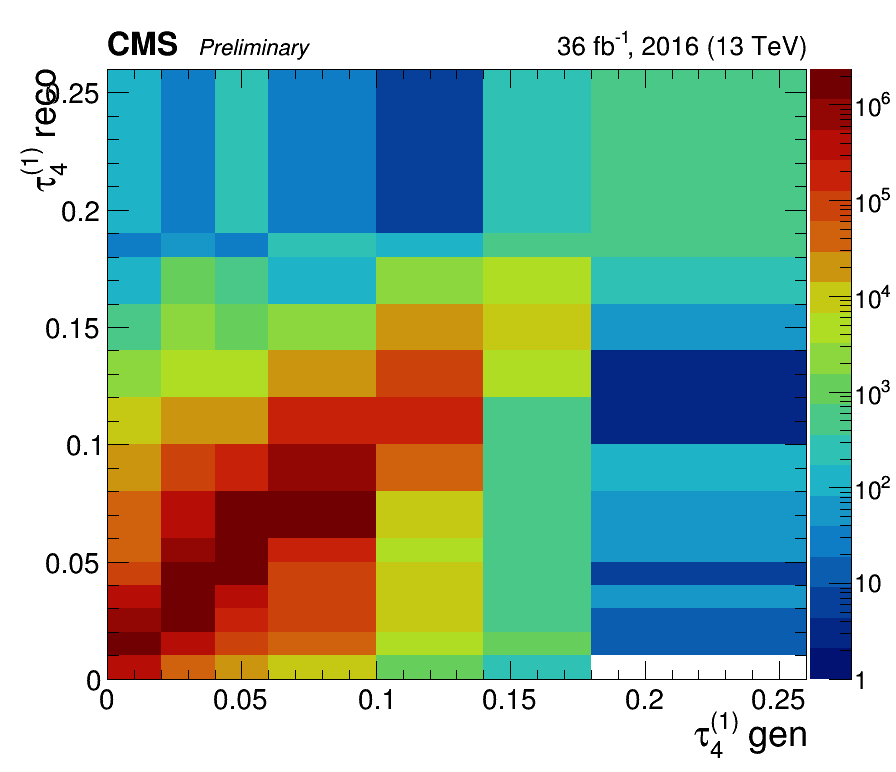

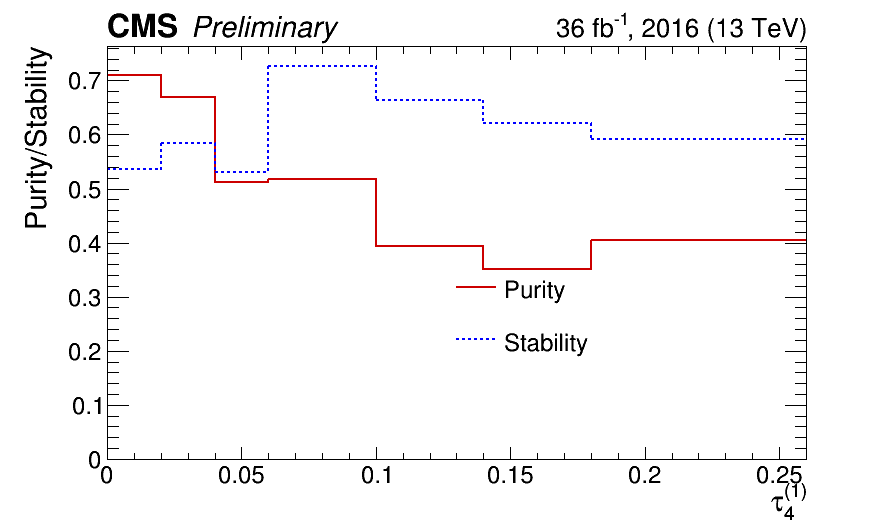

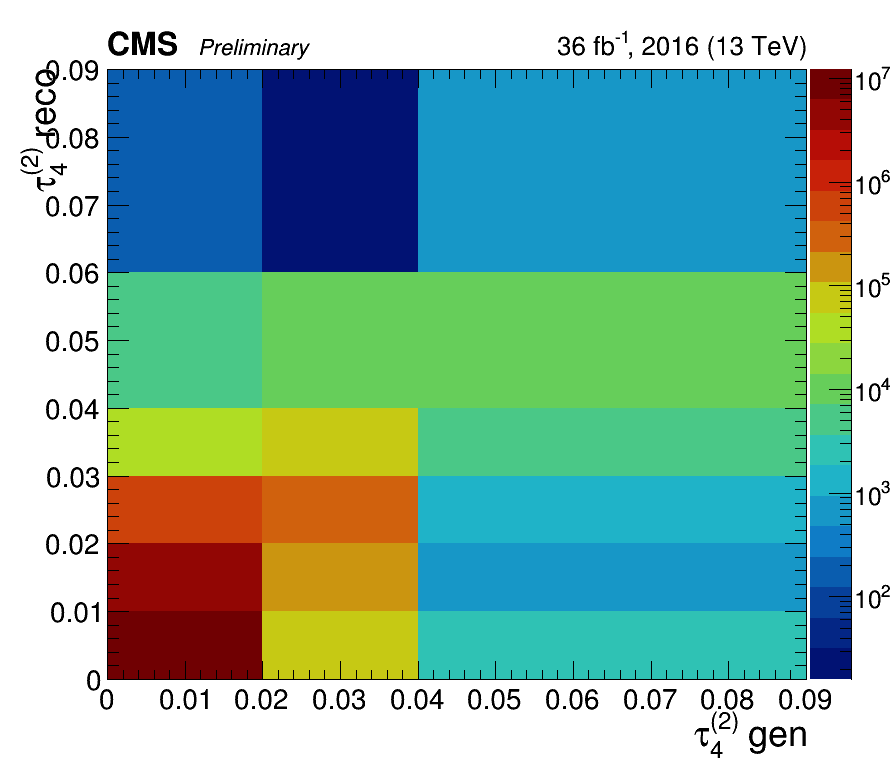

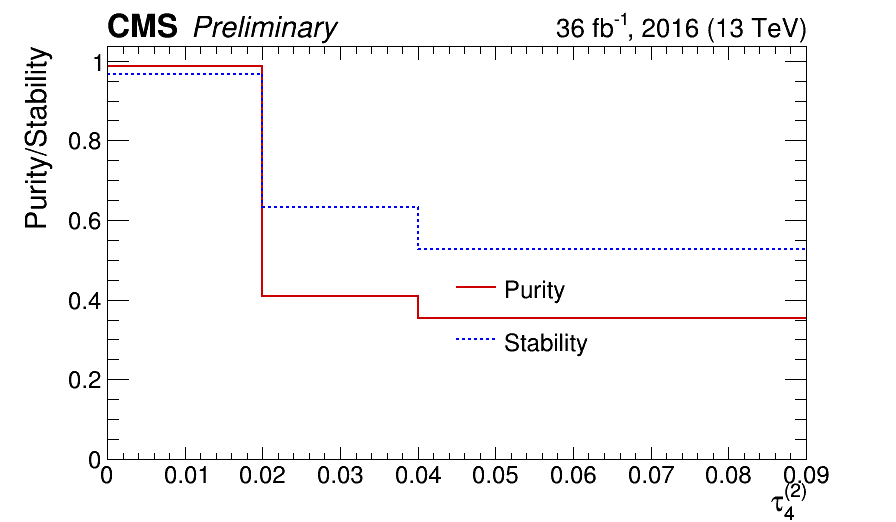

In [80]:
ps={}
cps={}
crm={}
leg={}
for var in variables:
    
    CMS_lumi.lumiTextSize=0.4
    CMS_lumi.cmsTextSize=0.5
    CMS_lumi.extraOverCmsTextSize=0.7
    CMS_lumi.relPosX=0.13
    crm[var]=rt.TCanvas("rm"+var,"rm"+var,0,0,900,800)
    crm[var].SetLogz()
    MC2[var].GetXaxis().SetTitleSize(0.05)
    MC2[var].GetXaxis().SetLabelSize(0.04)
    MC2[var].GetYaxis().SetTitleSize(0.05)
    MC2[var].GetYaxis().SetTitleOffset(0.9)
    MC2[var].GetYaxis().SetLabelSize(0.04)
    MC2[var].GetZaxis().SetLabelSize(0.035)
    MC2[var].GetZaxis().SetLabelOffset(-0.002)
    MC2[var].Draw("Colz")
    CMS_lumi.CMS_lumi(crm[var],4,0)
    crm[var].Draw()
    #crm[var].SaveAs("/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response"+var+".png")
    
    CMS_lumi.lumiTextSize=0.6
    CMS_lumi.cmsTextSize=0.75
    CMS_lumi.extraOverCmsTextSize=0.9
    CMS_lumi.relPosX=0.12
    cps[var]=rt.TCanvas("ps"+var,"ps"+var,0,0,900,550)
    ps[var]=rt.THStack("","")
    purity2[var].SetLineStyle(1)
    purity2[var].SetLineColor(rt.kRed+1)
    stability2[var].SetLineStyle(2)
    stability2[var].SetLineColor(rt.kBlue)
    ps[var].Add(purity2[var],"hist")
    ps[var].Add(stability2[var],"hist")
    ps[var].Draw("nostack")
    ps[var].GetXaxis().SetTitle(title[var])
    ps[var].GetYaxis().SetTitle("Purity/Stability")
    ps[var].GetYaxis().SetTitleSize(0.06)
    ps[var].GetYaxis().SetTitleOffset(0.8)
    ps[var].GetXaxis().SetTitleOffset(0.85)
    if var is "tau_1_2" or var is "tau_2_2":
        print "yes"
        leg[var]=rt.TLegend(0.5,0.2,0.75,0.4)
    else:
        leg[var]=rt.TLegend(0.5,0.3,0.75,0.5)
    leg[var].AddEntry(purity2[var],"Purity","l")
    leg[var].AddEntry(stability2[var],"Stability","l")
    leg[var].SetLineColor(0)
    leg[var].SetBorderSize(0)
    leg[var].SetFillStyle(0)
    leg[var].SetTextSize(0.05)
    leg[var].Draw("Same")
    CMS_lumi.CMS_lumi(cps[var],4,0)
    cps[var].Draw()
    cps[var].SaveAs("/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability"+var+".png")